## Dynamic Survival Transformers for Causal Inference with Electronic Health Records: 

### About the Project

In this project, I was able to reproduce the results from the paper "Dynamic Survival Transformers for Causal Inference with Electronic Health Records" by Prayag Chatha, et al. The paper is available here: [DynST Paper](https://arxiv.org/abs/<2210.15417>), and the code for the original paper is available here: [DynST Code](https://github.com/prob-ml/DynST). My repository is a fork of the original code, and I have made significant changes to the code in order to run the experiments in Google Colab, and to convert the code from python scripts to iPython notebooks. I have also updated the code to run the latest version of Pytorch and Pytorch Lightning, and incorporated Weights and Biases for experiment tracking. The original code dependencies are managed through Poetry, and the project code in the iPython notebooks are designed to run with the latest versions of Pytorch and Pytorch Lightning, on Google Colab. The notebooks will install the necessary dependencies. My code is located here: [My DynST Code](https://github.com/conlinm/DynST) and my paper regarding this project is available here: [My DynST Paper](https://drive.google.com/file/d/1Azy3GJu5RaN-u5M1Hq0yToc10HW4R84n/view?usp=sharing)

### Data

The MIMIC-III dataset is a large dataset of de-identified health data. It is available from the Physionet website: https://physionet.org/content/mimiciii/1.4/. It contains health related data from patients who were admitted to the critical care units of Beth Isreal Deaconess Medical Center from 2001 to 2012. It consists of both static and dynamic data. In addition to patient demographics, there is data acquired from the hospital that is not necessarily related to the patient's intensive care unit (ICU) stay, and the data related to the ICU stay such as vital signs, laboratory tests, diagnostic codes, medications, etc. This includes data from bedside monitoring systems, and the "chart" (electronic health record) data including provider's notes.
Patient Characteristics:
There are data associated with 53,423 distinct adult (age 16 and above) hospital admissions of 38,597 distinct adult patients. There are also data for 7870 neonate admissions, which we will eliminate from our data for analysis.

#### MIMIC-Extract data
MIMIC Extract is an open source pipeline to "extract, preprocess, and represent data from MIMIC-III v1.4.", as described in the paper "MIMIC-Extract: A Data Extraction, Preprocessing, and Representation Pipeline for MIMIC-III." (arXiv:1907.08322). The code is available at: [MIMIC_Extract](https://github.com/MLforHealth/MIMIC_Extract).
The extraction process results in data that includes well-formatted time-series data for clinically-meaningful prediction tasks. The time-varying data are discretized into hourly buckets, standardized, and aggregated into clinically meaningful representations.
The cohort of patients includes all adult patients whose ICU stay is their first, and that stay lasts at least 12 hours, and less that 10 days. This represents a generic cohort, not task-specific, and therefore can be adapted for many different clinical prediction tasks.
The extraction procedure is extensible and you may configure the cohort selection process. Using the default parameters for cohort selection, the data consists of 34,472 patients.About the all_hourly_data.h5 file:  It is a large file that contains all the hourly data for all patients in the MIMIC-III database. The "all_hourly_data.h5" file is the result of the pipeline using the default parameters, and is supplied by the authors of the MIMIC-Extract paper. The file is available for download from Google Cloud (with appropriate credentialing from [Physionet](https://mimic.mit.edu/docs/gettingstarted/)), and a link is provided on the MIMIC_Extract GitHub page.

The h5 datafile format is a hierarchical data format that is optimized for storing large amounts of data. It is a binary format, and is not human-readable. The data is stored in a hierarchical filesytem-like format, with each node in the hierarchy being a group or a dataset. A group is a container that can hold datasets and other groups. A dataset is a multidimensional array of data elements. The data can be read directly into a pandas dataframes, which is what we will do in this notebook.

### How to use

To begin, you will need the MIMIC-Extract file `all_hourly_data.h5` saved in a directory called `data/`. This file is available directly from [this google cloud folder](https://console.cloud.google.com/storage/browser/mimic_extract;tab=objects?prefix=&forceOnObjectsSortingFiltering=false) with the appropriate priveledges from physionet.org. More information can be found at the link above to the MIMIC-Extract repository.

You can then run the original paper's code from the command line, or the modified code for this project using the iPython notebooks (e.g., project_preprocess.ipynb and project_model.ipynb) in the repo.

This notebook will not preprocess the data or train the model. It will only be used to describe the project and the steps taken to complete it.

### Preprocessing the data

### Mimic3Pipeline Class
This class contains functions which prepare the data for analysis. The source of the data is the h5 file that is the output of the MIMIC-Extract pipeline. The data is read into a pandas dataframes, and processed to prepare it for analysis. The processing steps include:
- filtering out stays that are less than 16 hours or greater than 128
- replace age values > 90 with 90
- standardize the continuous variables
- create the synthetic hazard function according to the formula in the paper:
  $$h(t) = H_o exp(-\lambda t) * exp(\theta A) * exp(\sum_{j=1}^{4}\beta_j Z_j)* exp(log(1.02)tZ_*) * exp(\sum_{j=1}^{4}\gamma_j g(V_j^{(t)}))$$
  where:
    - $H_o$ is the baseline hazard function
    - \lambda is the decay rate of the hazard function (risk decreases with time)
    - A is the binary treatment indicator, and $\theta$ is the treatment effect (treatment decreases risk)
    - $Z_j$ are the four static variables, and $\beta_j$ are the coefficients for the static variables
    - $Z_*$ is the indicator for severe illness, and $tZ_*$ is the interaction term between $Z_*$ and time
    - $V_j^{(t)}$ are the four time-varying variables (hematocrit, hemoglobin, platelets, mean blood pressure), and $\gamma_j$ are the coefficients for the time-varying variables
  - calculate the survival probabilites for each patient at each hour
  - using the survival probabilities, calculate the survival status for each patient at each hour
  - calculate the average treatment effect (ATE)

The output of this class is the csv file which contains the processed and synthetic data, and a series of numpy arrays for use by the Mimic3Dataset class.

Below is a plot of the baseline hazard function which includes the decreasing risk the longer they survive (the Lindy effect)

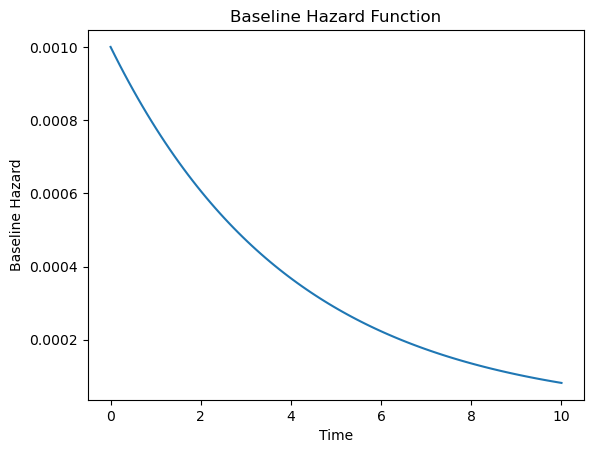

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Define the function
def baseline_hazard(t):
    return 0.001 * np.exp(-0.25 * t)

# Define the time array
t = np.linspace(0, 10, 100)

# Calculate the baseline hazard values
baseline_hazard_values = baseline_hazard(t)

# Create the plot
plt.plot(t, baseline_hazard_values)
plt.xlabel('Time')
plt.ylabel('Baseline Hazard')
plt.title('Baseline Hazard Function')
plt.show()


After the preprocessing is complete, the data is saved to a csv file, and the numpy arrays are saved to a folder in the data directory.

The preprocessed semi-synthetic data has the following summary statistics:

| Item                              | Value               |
| --------------------------------- | ------------------- |
| Total Patients                    | 30,323              |
| Censored                          | 39.32%              |
| Mean time to censoring or failure | 27.78 hours         |
| Mean restricted survival time     | 13 hours (tau = 16) |
| Observed treatment effect         | -0.93 hours         |
| True treatment effect             | 0.95 hours          |

#### Results from Training Runs
Measuring mean abosulte error during training

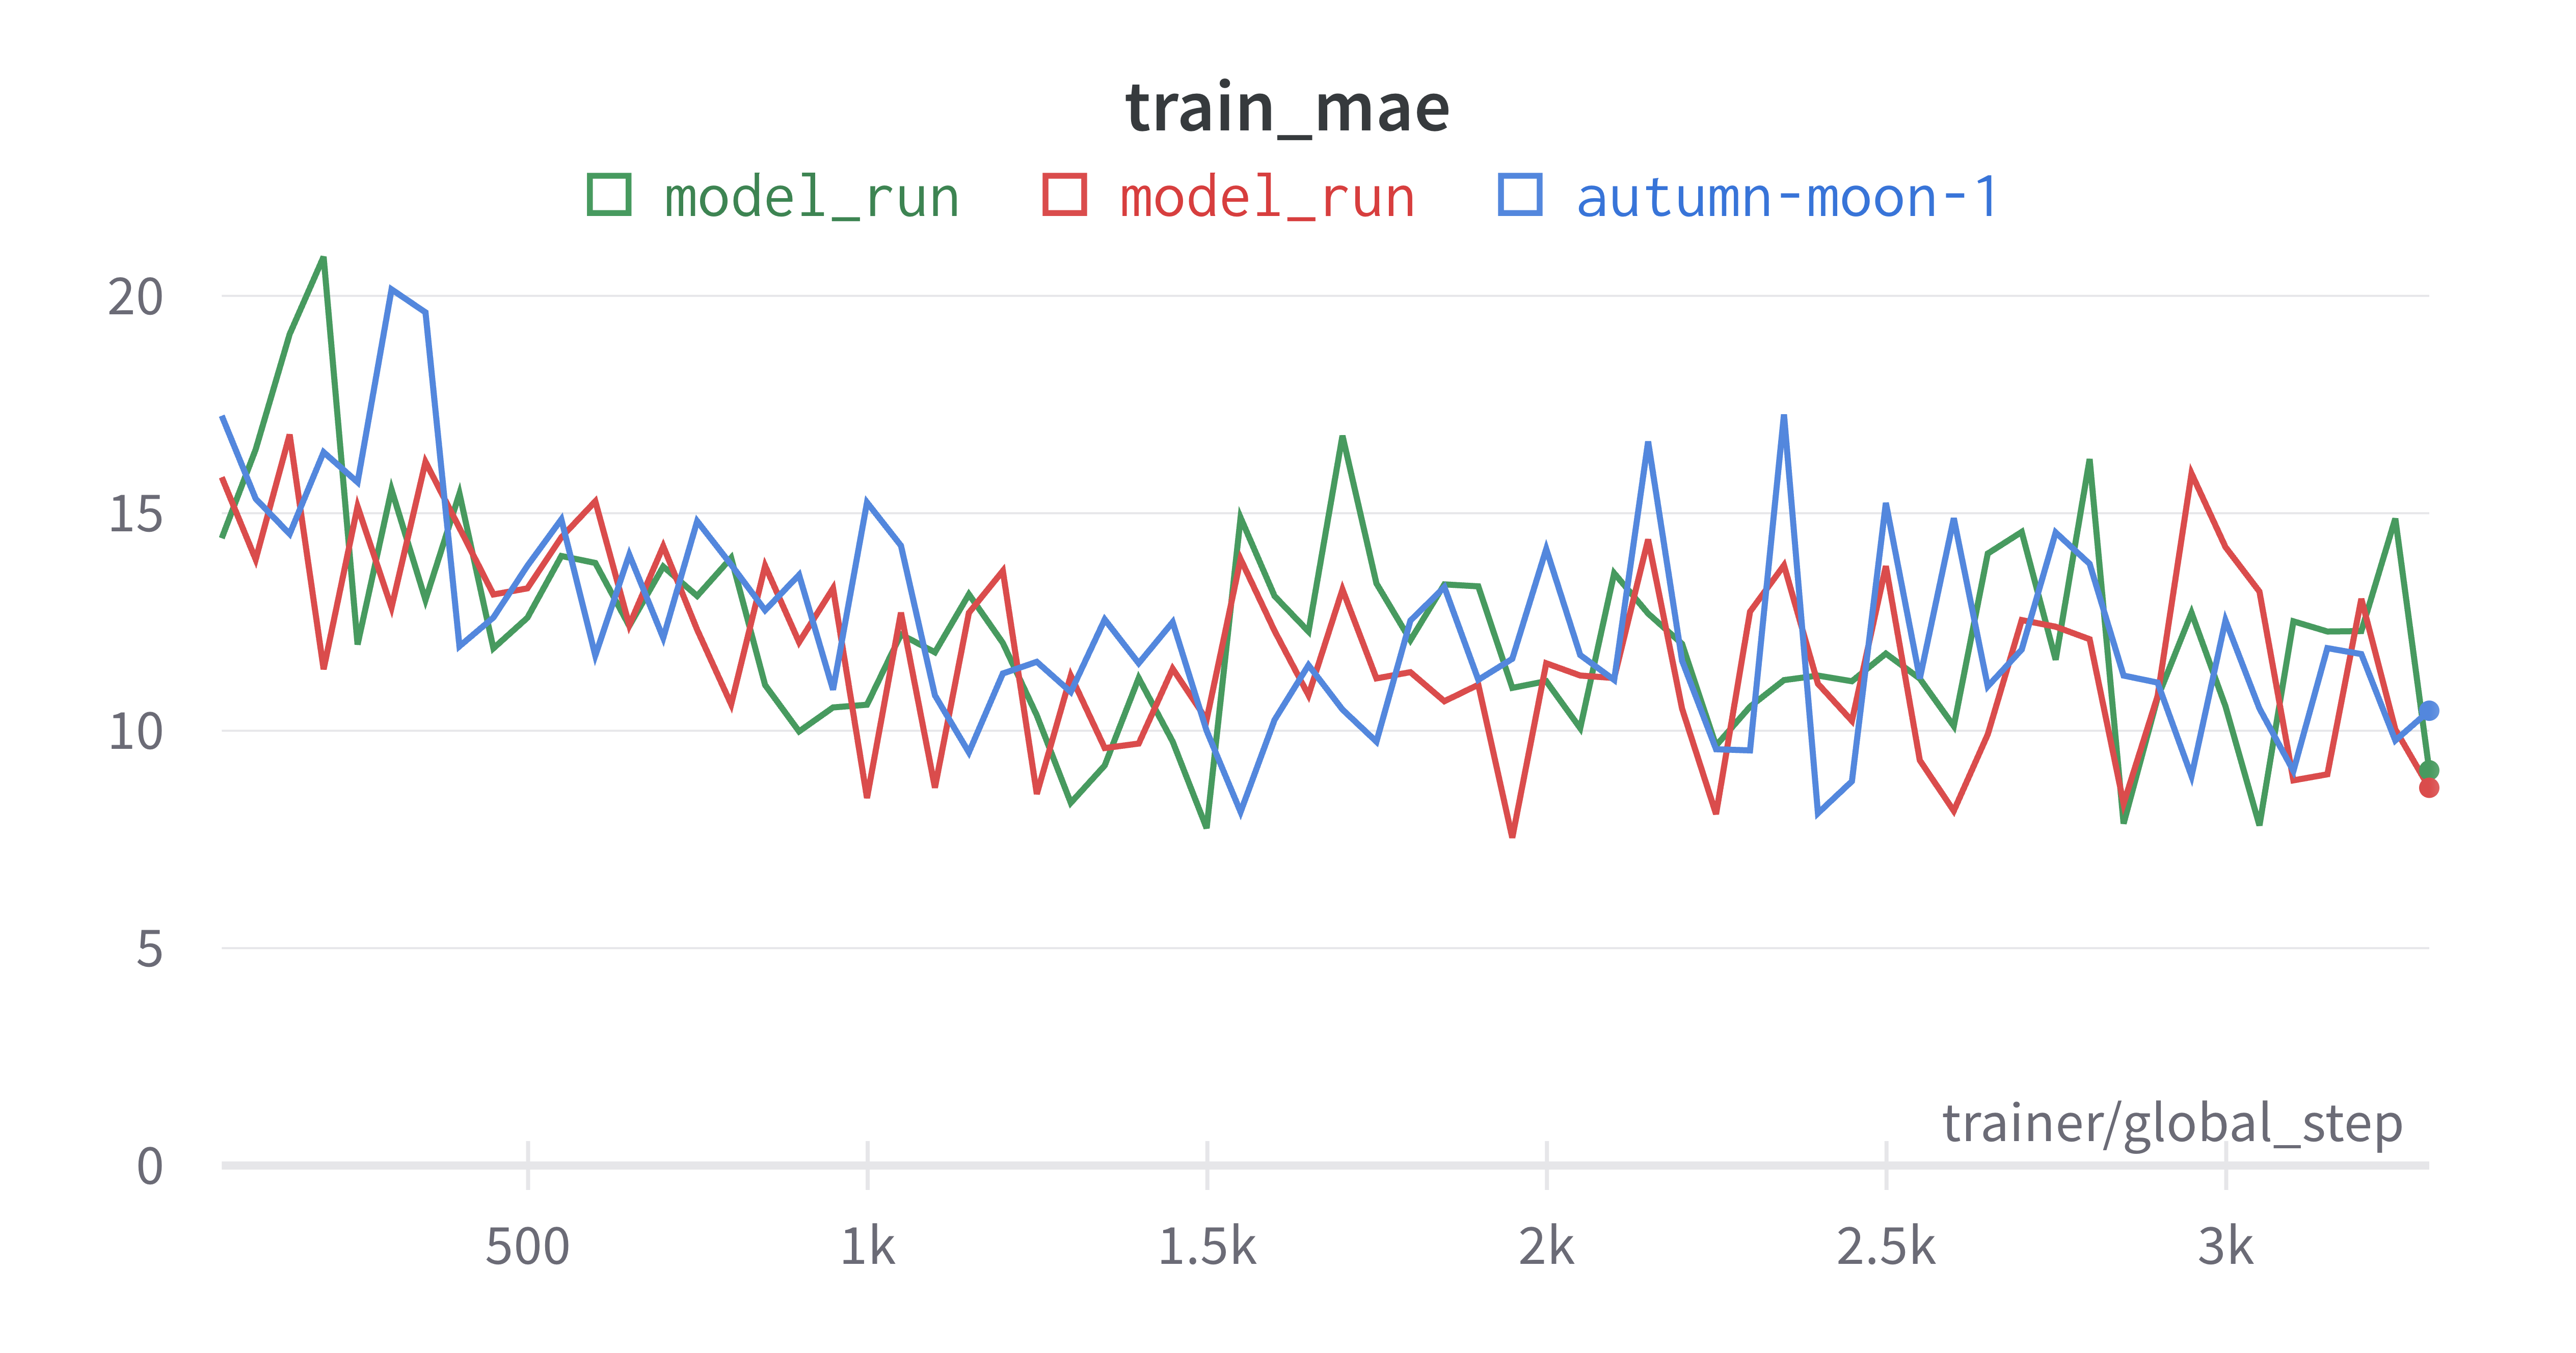

In [4]:
from IPython.display import Image
Image('data/W&B Chart 5_8_2023, 9_03_42 PM.png')

#### Results from validation runs

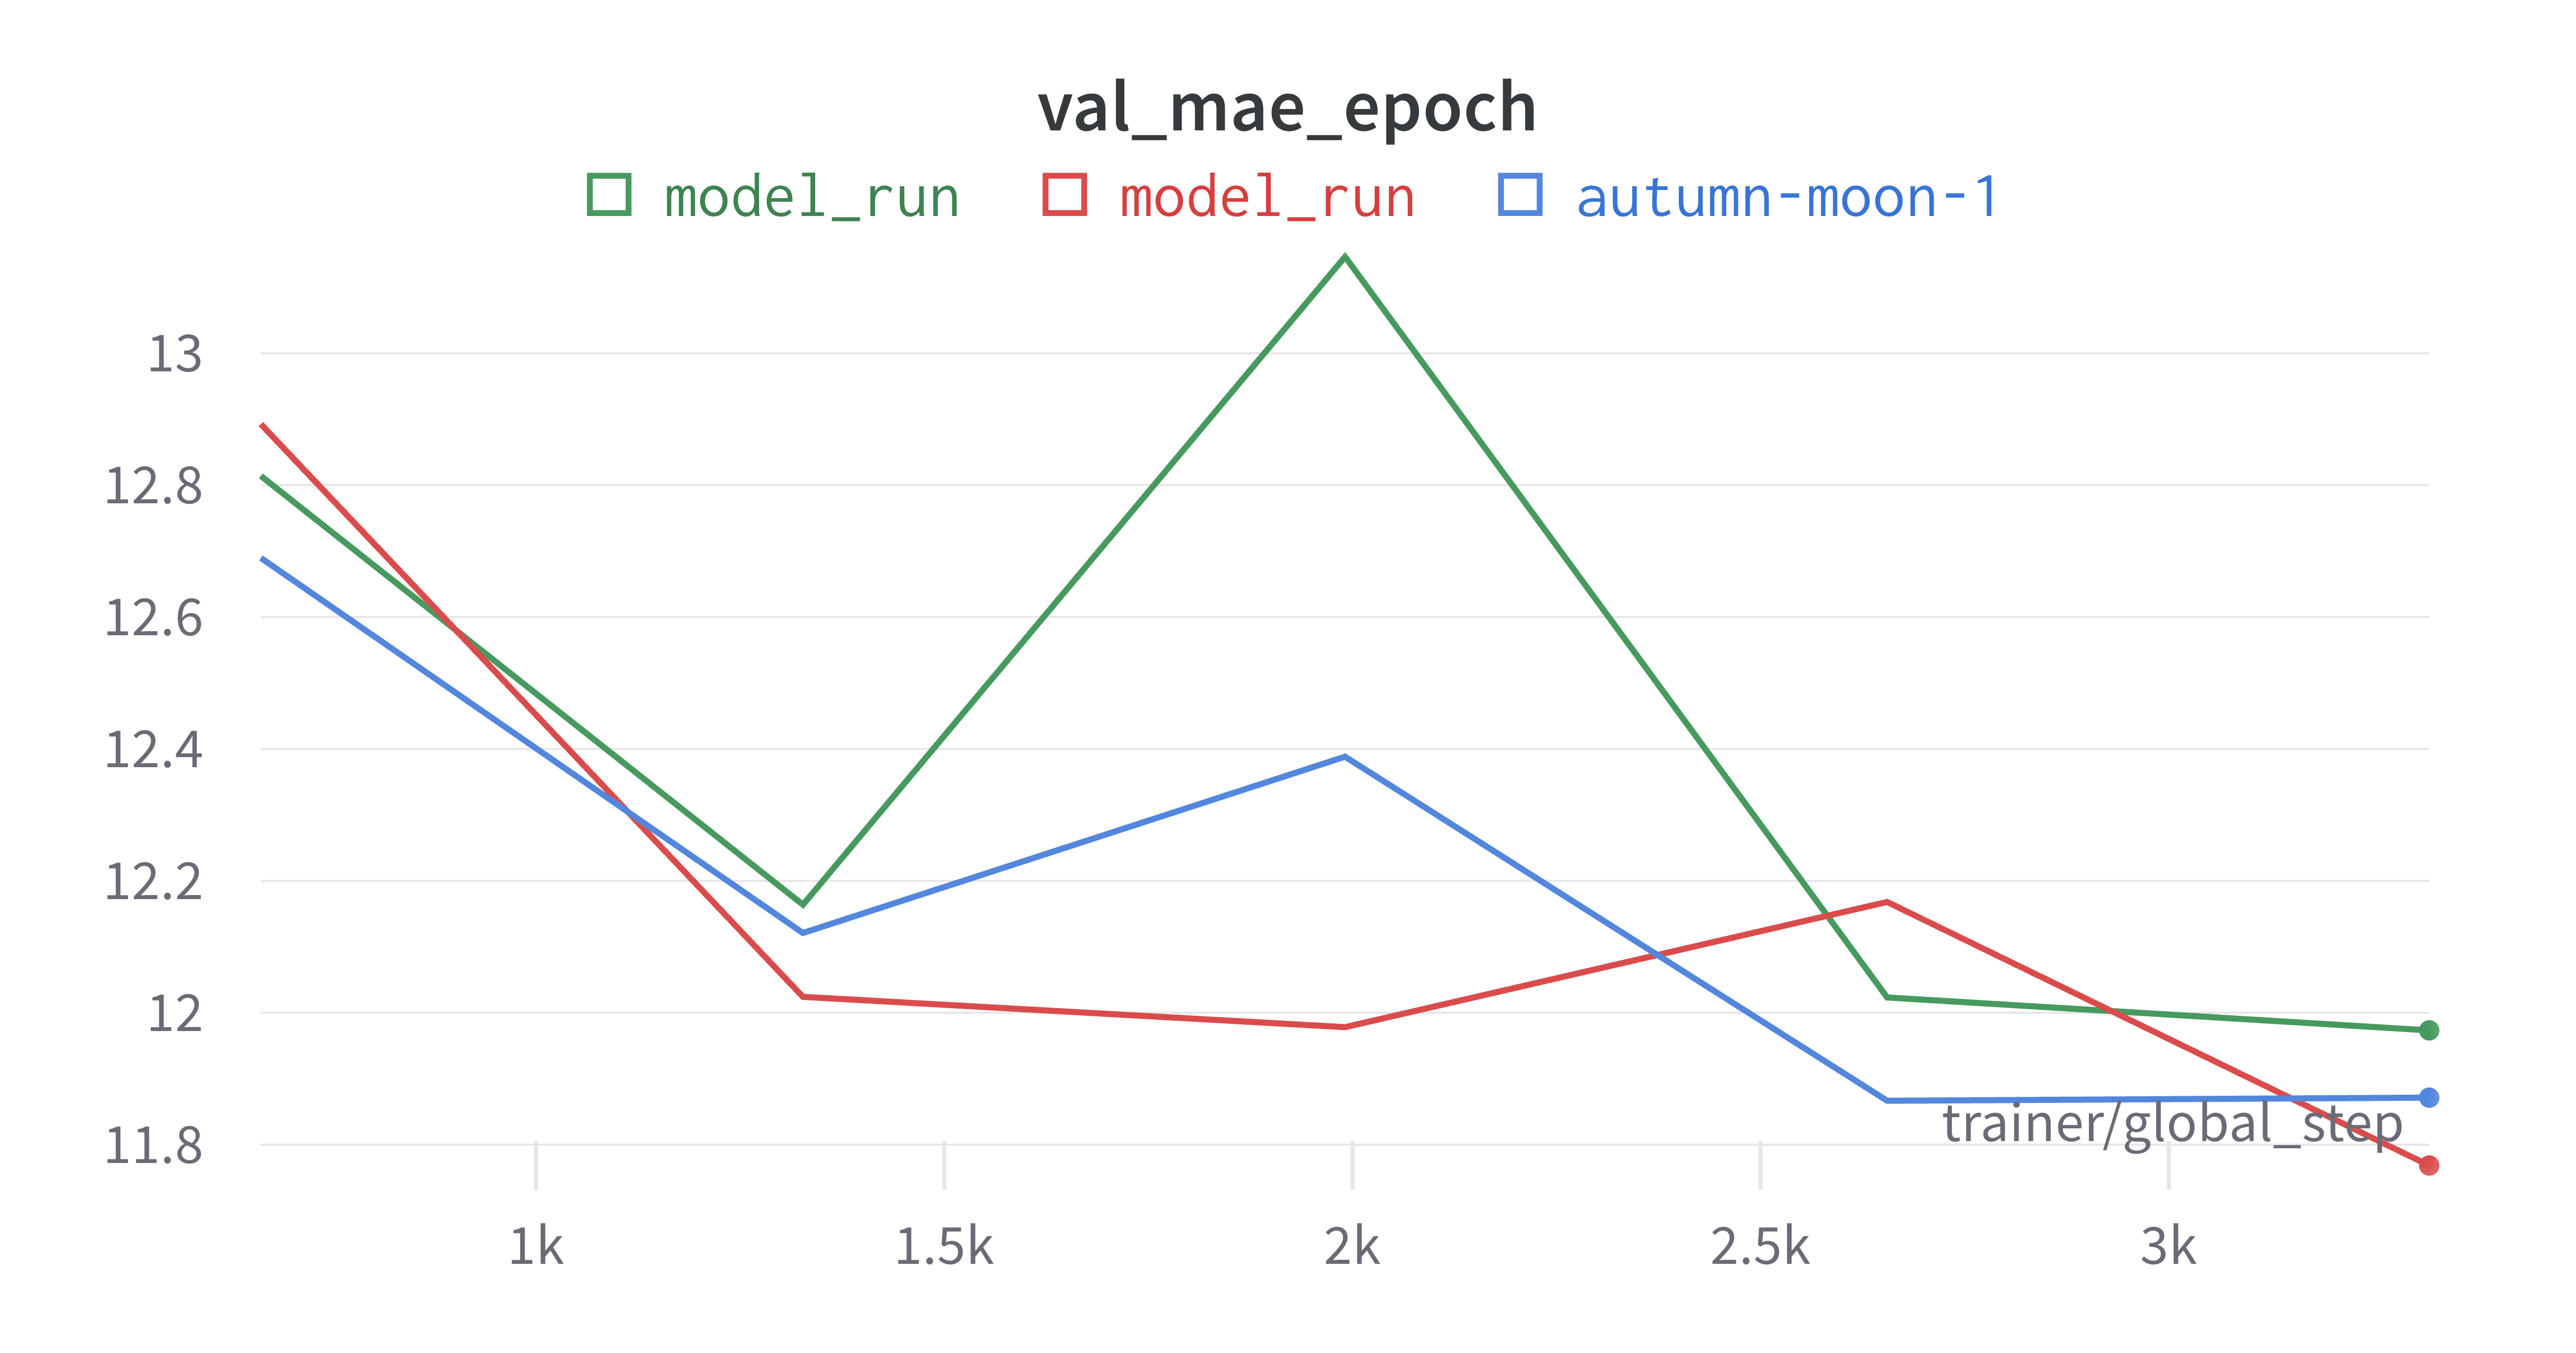

In [3]:
from IPython.display import Image
Image('data/W&B Chart 5_7_2023, 7_25_11 PM.png')

### Results

I was able to reproduce the results of the original paper and confirm the conclusions. The results confirm that the DynST approach performs better than the Cox model or the static ST approach. The DynST approach also performs better than the logistic IPW estimator for the average treatment effect on restricted mean survival time (RMST). 

##### Predictive model results
(reported in Mean Absolute Error)

| Model       | MAE (reproduction) | MAE (reported)    | \% difference |
|-------------|-------------------|------------------|---------------|
| Cox Model | 16.04 +/- 0.25  | 16.04 +/- 0.25 | 0             |
| Static ST | 11.42 +/- 0.23  | 11.42 +/- 0.23 | 0             |
| DynST     | 11.17 +/- 0.72  | 11.19 +/- 0.24 | 0.2         |


##### Causal Inference Results
(the estimators of average treatment effect on RMST is reported as the bias +/- standard deviation)

| Model          | 	tau = 8          | tau = 12         | tau = 16         |
|----------------|--------------------|---------------------|---------------------|
| Cox Model    | -0.260 +/- 0.001 | -0.523 +/- 0.0012 | -0.750 +/- 0.0080 |
| Logistic IPW | 0.257 +/- 0.0    | 0.35 +/- 0.0      | 0.416 +/- 0.0     |
| DynST        | -0.146 +/- 0.041 | -0.160 +/- 0.078  | -0.190 +/- 0.12   |
